# Adaboost 
- 以决策树桩(单层决策树)作为基分类器的Adaboost

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

## Decesion tree stump(决策树桩) 
- 决策树桩算法，即只有一层的决策树，即只选择一个属性进行划分；无疑，决策树桩是一个弱学习器
- 在本文中实现的决策树桩算法是基于属性值为连续值这一假设进行设计的，具体算法如下
  1. 遍历训练数据的所有属性，分别对每一属性值的属性区间按照一定步长进行分割；
  2. 在每一个分割点，分别 设置小于等于分割点的一侧，记为“左边”与大于分割点的一侧，记为“右边”，分别设置左边为正类(+1)或负类(-1)
  3. 使用训练数据选择最优的一个包括**属性值、属性分割点、“左边为正类或负类”**的三元组，作为模型输出，其中最优的标准是训练数据在该选择下具有最小的错误率  
  
- 下图是一个具体的例子，展示了作为一个弱学习器，决策树桩无论如何也不能在该数据集上达到百分之百的训练准确率
- (Decesion tree stump)决策树桩实际上是只有一层的CART树

In [67]:
class stump_classify:
    def __init__(self, train_X, train_y, valid_X=None, valid_y=None):
        """
        type train_X:[[]]
        type train_y:[]
        type valid_X:[[]]
        type valid_y:[]
        """
        self.train_X = train_X
        self.train_y = train_y
        self.valid_X = valid_X
        self.valid_y = valid_y

    def fit(self, num_steps, wrong_wei):
        """
        type num_steps:int, 属性值空间的划分次数
        type wrong_wei:[float], 每条数据对应的权重
        """
        m, n = self.train_X.shape
        thread_ineqs = ["left_true", "right_true"]
        min_error = float("inf")
        parameter_dic = {}
        for i in range(n):
            cur_dimen_min = self.train_X[:, i].min()
            cur_dimen_max = self.train_X[:, i].max()
            thread_range = cur_dimen_max - cur_dimen_min  # 当前属性的值区间
            for thread_val in np.linspace(cur_dimen_min, cur_dimen_max, num_steps):
                for thread_ineq in thread_ineqs:
                    pre = self.predict(dimen=i, thread_val=thread_val, thread_ineq=thread_ineq, \
                                       test_X=self.train_X)
                    cur_score = self.evaluate(self.train_y, pre, wrong_wei)
                    if cur_score < min_error:
                        min_error = cur_score
                        parameter_dic['dimen'] = i
                        parameter_dic['thread_val'] = thread_val
                        parameter_dic['thread_ineq'] = thread_ineq
        return parameter_dic

    # 三个参数可以看做是学习得到的三个参数，最终的模型也是使用这三个参数来表示的
    def predict(self, dimen, thread_val, thread_ineq, test_X):
        """
        type dimen:int, 使用哪个维度作为划分属性
        type thread_val:float, 使用 dimen>thread_val 与 dimen<=thread_val 划分为两部分
        type thread_ineq:str, 表明 dimen>thread_val 属于那个类别
        rtype [], 预测结果
        """
        m, _ = test_X.shape
        pre = np.ones(m)
        if thread_ineq == "left_true":
            pre[test_X[:, dimen] <= thread_val] = -1
        else:
            pre[test_X[:, dimen] > thread_val] = -1
        return pre

    def evaluate(self, test_y, pre, wrong_wei, score=None):
        if score == None:
            return np.sum((test_y != pre).astype(int) * wrong_wei)  # 默认以加权错误分类数作为评价指标
        else:
            return score(test_y, pre)

### 测试 stump-tree(决策树桩) 

In [4]:
def load_simple_data():
    data = np.array(
        [[1, 2.1],
         [2, 1.1],
         [1.3, 1],
         [1, 1],
         [2, 1]])
    label = np.array([1, 1, 0, 0, 1])
    return (data, label)

In [5]:
x, y = load_simple_data()

In [6]:
stump = stump_classify(x, y)

In [7]:
para = stump.fit(5, np.ones(len(x)))

In [8]:
stump.predict(test_X=x, **para)

array([ 0.,  1.,  0.,  0.,  1.])

In [9]:
print para

{'dimen': 0, 'thread_ineq': 'right_true', 'thread_val': 1.5}


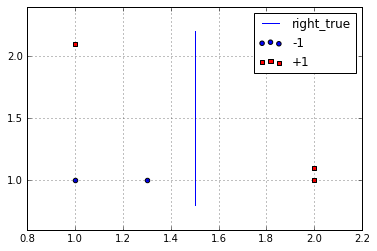

In [80]:
plt.scatter(x[y == 0,0], x[y==0,1], c='blue', label="-1", marker="o")
plt.scatter(x[y == 1,0], x[y==1,1], c='red', label="+1", marker="s")
ylim = plt.ylim()
plt.plot([para['thread_val'],para['thread_val']],ylim, label=para['thread_ineq'])
plt.legend()
plt.grid()
plt.savefig('stump.png')

***蓝色直线表示右边部分被分类为正类，左边被分类为负类,即使是单阶段最优的决策树桩也无法完全区分如上图分布的样本，通过AdaBoost算法则可以做到***

## AdaBoost(adaptive boost) 算法 
1. 为每个训练样本初始化相同的权重，方便起见，将其记为向量 $W$
2. 开始一轮训练，在本轮训练完成后，判断是否达到迭代次数阈值或者错误率已经达到阈值，如果是，则输出模型，结束训练，否则转3
3. 根据本轮训练模型在训练集上的表现，更新 $W$，转到2  


- 上述的三个步骤中，第三步的权重更新规则的制定是最为关键的，一般的算法如下：


1. 定义错误分类数 $\epsilon = \frac{未正确分类的样本数目}{全部样本数目}$  
2. 定义权重因子 $\alpha = \frac{1}{2}\ln {\frac{1-\epsilon}{\epsilon}}$
3. 定义权重向量更新规则  
  - 如果样本 $W_{i}$第 $t$ 轮被正确分类，则 $W_{i}^{t+1} = \frac{W_{i}^{t}\exp (-\alpha)}{\sum{W}}$   
  
  - 如果样本 $W_{i}$第 $t$ 轮被错误分类，则 $W_{i}^{t+1} = \frac{W_{i}^{t}\exp (\alpha)}{\sum{W}}$ 

## 基于弱分类器(decison stump)的强分类器(AdaBoost) 

In [68]:
def adaboost_stump(train_x, train_y, epochs=40, error_rate_bound=0.0):
    """
    type train_x   :[[]]
    type train_y   :[[]]
    type epochs    :int
    type error_rate:float
    """
    weak_classifier_arr = []  # 用来存放每轮的弱分类器
    m, _ = train_x.shape
    wrong_weight = np.ones(m, dtype=np.float32) / m  # 初始权重向量
    error_rate_arr = []  # 方便观察错误率的变化
    agg_class_est = np.ones(m)
    for i in range(epochs):
        weak_classifier = stump_classify(train_x, train_y)
        weak_model = weak_classifier.fit(10.0, wrong_weight)
        weak_classifier_arr.append(weak_model)
        pre = weak_classifier.predict(test_X=train_x, **weak_model)
        error_rate = weak_classifier.evaluate(train_y, pre, wrong_weight)  # 加权错误数

        alpha = 0.5 * np.log((1 - error_rate) / max(error_rate,1e-16))  # 防止出现除数为0的异常

        # 更新权重向量
        wrong_weight *= np.exp(-pre * train_y * alpha)
        wrong_weight = wrong_weight / np.sum(wrong_weight)  # 归一化处理

        weak_model['alpha'] = alpha
        agg_class_est += alpha*pre  # 加权估计器的预测结果

        # 本轮及本轮之前所有弱分类器的加权平均估计错误率
        agg_error_rate = np.sum((np.sign(agg_class_est) != train_y).astype(int))/float(m)

        error_rate_arr.append(agg_error_rate)
        if agg_error_rate <= error_rate_bound:
            break
    return (weak_classifier_arr, error_rate_arr)

In [75]:
def adaboost_stump_predict(weak_classifier, test_x):
    pre = np.zeros(test_x.shape[0])
    for item in weak_classifier:
        stump_tree = stump_classify(train_X=None, train_y=None)
        cur_pre = stump_tree.predict(dimen=item['dimen'], thread_val=item['thread_val'], \
                           thread_ineq=item['thread_ineq'], test_X=test_x)
        pre += cur_pre*item['alpha']
    return np.sign(pre)

## 测试基于 Decesion tree stump(决策树桩)的AdaBoost算法

### 导入 breast_canser 数据集 

In [38]:
from sklearn.datasets import load_breast_cancer
datas = load_breast_cancer()

In [39]:
datas_x = datas.data
datas_y = datas.target

In [40]:
print datas_x.shape

(569, 30)


In [42]:
datas_y[datas_y == 0] = -1
datas_y.min()

-1

In [43]:
from sklearn.decomposition import pca

In [49]:
bre_can_pca = pca.PCA(n_components=2)

In [50]:
bre_can_pca.fit(datas_x)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [51]:
bre_can_2d = bre_can_pca.transform(datas_x)
bre_can_2d.shape

(569, 2)

In [53]:
positive_x = bre_can_2d[datas_y == 1]
negative_x = bre_can_2d[datas_y == -1]

In [54]:
print positive_x.shape
print negative_x.shape

(357, 2)
(212, 2)


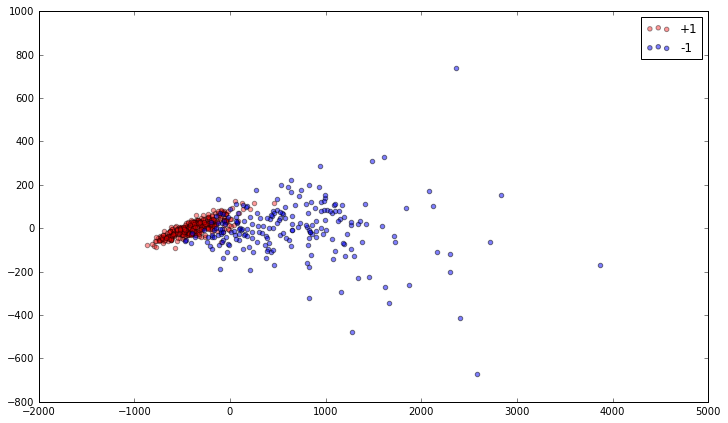

In [82]:
fig = plt.figure(figsize=(12,7))
plt.scatter(positive_x[:,0], positive_x[:,1], c="red", label="+1", alpha=0.4)
plt.scatter(negative_x[:,0], negative_x[:,1], c="blue", label="-1", alpha=0.5)
plt.legend()
plt.savefig('distribution.png')

### 将 breast_cancer 数据集随机分割 

In [63]:
from sklearn.model_selection import train_test_split

In [64]:
train_x, test_x, train_y, test_y = train_test_split(datas_x, datas_y, test_size=0.3)

In [65]:
print train_x.shape
print test_x.shape

(398, 30)
(171, 30)


### 训练AdaBoost模型 

In [69]:
week_classifiers, error_rates = adaboost_stump(train_x, train_y)

In [70]:
week_classifiers

[{'alpha': 1.2356873275921554,
  'dimen': 22,
  'thread_ineq': 'right_true',
  'thread_val': 110.04000000000001},
 {'alpha': 0.88388242671555195,
  'dimen': 7,
  'thread_ineq': 'right_true',
  'thread_val': 0.042511111111111111},
 {'alpha': 0.64124830787319442,
  'dimen': 1,
  'thread_ineq': 'right_true',
  'thread_val': 19.56666666666667},
 {'alpha': 0.54168801089118945,
  'dimen': 10,
  'thread_ineq': 'right_true',
  'thread_val': 0.42091111111111118},
 {'alpha': 0.45963716676423921,
  'dimen': 21,
  'thread_ineq': 'right_true',
  'thread_val': 19.828888888888891},
 {'alpha': 0.66469094441888255,
  'dimen': 27,
  'thread_ineq': 'right_true',
  'thread_val': 0.16166666666666665},
 {'alpha': 0.43175216406546546,
  'dimen': 18,
  'thread_ineq': 'left_true',
  'thread_val': 0.015778444444444446},
 {'alpha': 0.45998830291161702,
  'dimen': 17,
  'thread_ineq': 'right_true',
  'thread_val': 0.011731111111111111},
 {'alpha': 0.36582677161420396,
  'dimen': 21,
  'thread_ineq': 'right_true',

In [76]:
pre = adaboost_stump_predict(weak_classifier=week_classifiers, test_x=test_x)

In [77]:
from sklearn.metrics import accuracy_score,confusion_matrix

In [78]:
accuracy_score(y_pred=pre, y_true=test_y)

0.96491228070175439

In [79]:
confusion_matrix(y_pred=pre, y_true=test_y)

array([[68,  3],
       [ 3, 97]])